In [54]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
import imageio
from IPython.display import Image
import matplotlib.image as mpimg
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import zipfile
from io import BytesIO
from nibabel import FileHolder
from nibabel.analyze import AnalyzeImage
import PIL
from IPython import display
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import data, io, filters
import skimage
import imutils
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose, LeakyReLU, ReLU
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
from keras.datasets import mnist
import keras
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)


In [56]:
# Chobunsai_Eishi
# Ishikawa_Toyonobu

portpath = Path("apollo")
# portpath = Path("test2/imgdata")

portjpg = list(portpath.glob("*.jpg"))
portseries = pd.Series(portjpg,name="JPG").astype(str)

artpath = Path("apollo")
# artpath = Path("test2/imgdata")

artjpg = list(artpath.glob("*.jpg"))
artseries = pd.Series(artjpg, name="JPG").astype(str)

Brain_Image = []
for image_x in portseries[0:10].values:
    
    Reading_Image = cv2.cvtColor(cv2.imread(image_x),cv2.COLOR_BGR2RGB)
    Resized_Image = cv2.resize(Reading_Image,(100,100))
   
    Brain_Image.append(Resized_Image)
print('port')
    
Night_Frame = []
for image_x in artseries[0:10].values:

    Reading_Image = cv2.cvtColor(cv2.imread(image_x),cv2.COLOR_BGR2RGB)
    Resized_Image = cv2.resize(Reading_Image,(100,100))
   
    Night_Frame.append(Resized_Image)
    


Total_List = []

for brain_x,universe_x in zip(Brain_Image,Night_Frame):
    Total_List.append(brain_x)
    Total_List.append(universe_x)

port


In [57]:
iterations = 600
vector_noise_shape = 100
count_example = 20
batch_size = 12
count_buffer = 60000

In [58]:
seed = tf.random.normal([count_example,vector_noise_shape])

#### DATA TRANSFORMATION

In [59]:
X_Train = np.array(Total_List)

X_Train = X_Train.astype("float32")

In [60]:
X_Train = X_Train[:1000]

In [61]:
X_Train = X_Train / 255.

In [62]:
print("TOTAL SHAPE: ",X_Train.shape)

TOTAL SHAPE:  (20, 100, 100, 3)


#### TENSOR SLICES

In [63]:
Train_Data = tf.data.Dataset.from_tensor_slices(X_Train).shuffle(count_buffer).batch(batch_size)

In [64]:
# print(Tensor_Data.element_spec)

#### GENERATOR PROCESS

In [65]:
def Generator_Model():
    
    
    Model = Sequential()
    #
    Model.add(Dense(50*50*128,use_bias=False,input_shape=(100,)))
    Model.add(BatchNormalization())
    Model.add(LeakyReLU())
    #
    Model.add(Reshape((50,50,128)))
    #
    Model.add(Conv2DTranspose(128,(3,3),padding="same",use_bias=False))
    Model.add(BatchNormalization())
    Model.add(LeakyReLU())
    
    Model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', use_bias=False))
    Model.add(BatchNormalization())
    Model.add(LeakyReLU())
    #
    Model.add(Conv2DTranspose(3,(3,3),padding="same",use_bias=False,activation="tanh"))
    
    
    return Model

In [66]:
Generator = Generator_Model()

#### DISCRIMINATOR PROCESS

In [67]:
def Discriminator_Model():
    
    Model = Sequential()
    
    Model.add(Conv2D(64,(3,3),padding="same",input_shape=[100,100,3]))
    Model.add(Dropout(0.2))
    Model.add(LeakyReLU())
    
    
    Model.add(Conv2D(128,(3,3),padding="same"))
    Model.add(Dropout(0.2))
    Model.add(LeakyReLU())
    
#     Model.add(Conv2D(360,(3,3),padding="same"))
#     Model.add(Dropout(0.2))
#     Model.add(LeakyReLU())
    
    Model.add(layers.Flatten())
    Model.add(layers.Dense(1))
    
    return Model

In [68]:
Discriminator = Discriminator_Model()

#### OPTIMIZERS

In [69]:
Generator_Optimizer = RMSprop(lr=0.0003,clipvalue=1.0,decay=1e-8)
Discriminator_Optimizer = RMSprop(lr=0.0003,clipvalue=1.0,decay=1e-8)

#### LOSS FUNCTIONS

In [70]:
Loss_Function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [71]:
def Discriminator_Loss(real_out,fake_out):
    
    real_loss_function = Loss_Function(tf.ones_like(real_out),real_out)
    fake_loss_function = Loss_Function(tf.zeros_like(fake_out),fake_out)
    total_loss = real_loss_function + fake_loss_function
    
    return total_loss

In [72]:
def Generator_Loss(fake_output):
    
    return Loss_Function(tf.ones_like(fake_output),fake_output)

#### GENERATING AND SAVING IMAGE

In [73]:
def display_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(predictions.shape[0]):
        plt.subplot(5, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('output_image{:04d}.png'.format(epoch))
    plt.show()

#### TRAINING STEP

In [74]:
def Train_Step(images):
    
    random_noise_vector = tf.random.normal([batch_size,vector_noise_shape])
    
    with tf.GradientTape() as Generator_Tape, tf.GradientTape() as Discriminator_Tape:
        
        Generator_Fake_Image = Generator(random_noise_vector,training=False)
        
        real_output = Discriminator(images,training=True)
        fake_output = Discriminator(Generator_Fake_Image,training=True)
        
        Generator_Loss_Output = Generator_Loss(fake_output)
        Discriminator_Loss_Output = Discriminator_Loss(real_output,fake_output)
        
    Generator_Gradients = Generator_Tape.gradient(Generator_Loss_Output,Generator.trainable_variables)
    Discriminator_Gradients = Discriminator_Tape.gradient(Discriminator_Loss_Output,Discriminator.trainable_variables)
    
    Generator_Optimizer.apply_gradients(zip(Generator_Gradients,Generator.trainable_variables))
    Discriminator_Optimizer.apply_gradients(zip(Discriminator_Gradients,Discriminator.trainable_variables))


#### TRAINING

In [75]:
def Training(dataset,iterations):
    
    for epoch in range(iterations):
        start = time.time()
        
        print(epoch)
        for image_batch in dataset:
            Train_Step(image_batch)
            
            
        display.clear_output(wait=True)
        display_and_save_images(Generator,epoch+1,seed)
    
    display.clear_output(wait=True)
    display_and_save_images(Generator,epoch,seed)  

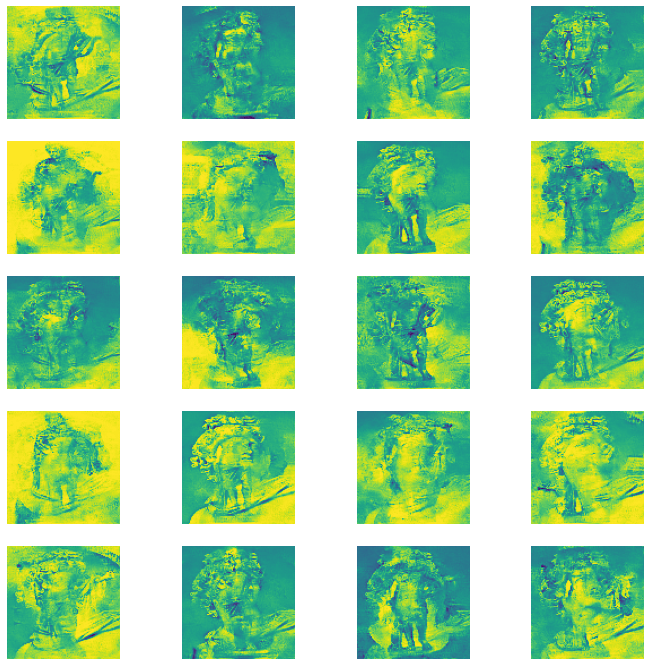

In [76]:
Training(Train_Data,iterations)

#### PREDICTION

In [77]:
Predict_Generator_Noise = tf.random.normal(shape=[50,vector_noise_shape])

In [78]:
print(len(Predict_Generator_Noise))

50


In [79]:
Generator_Predict = Generator(Predict_Generator_Noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


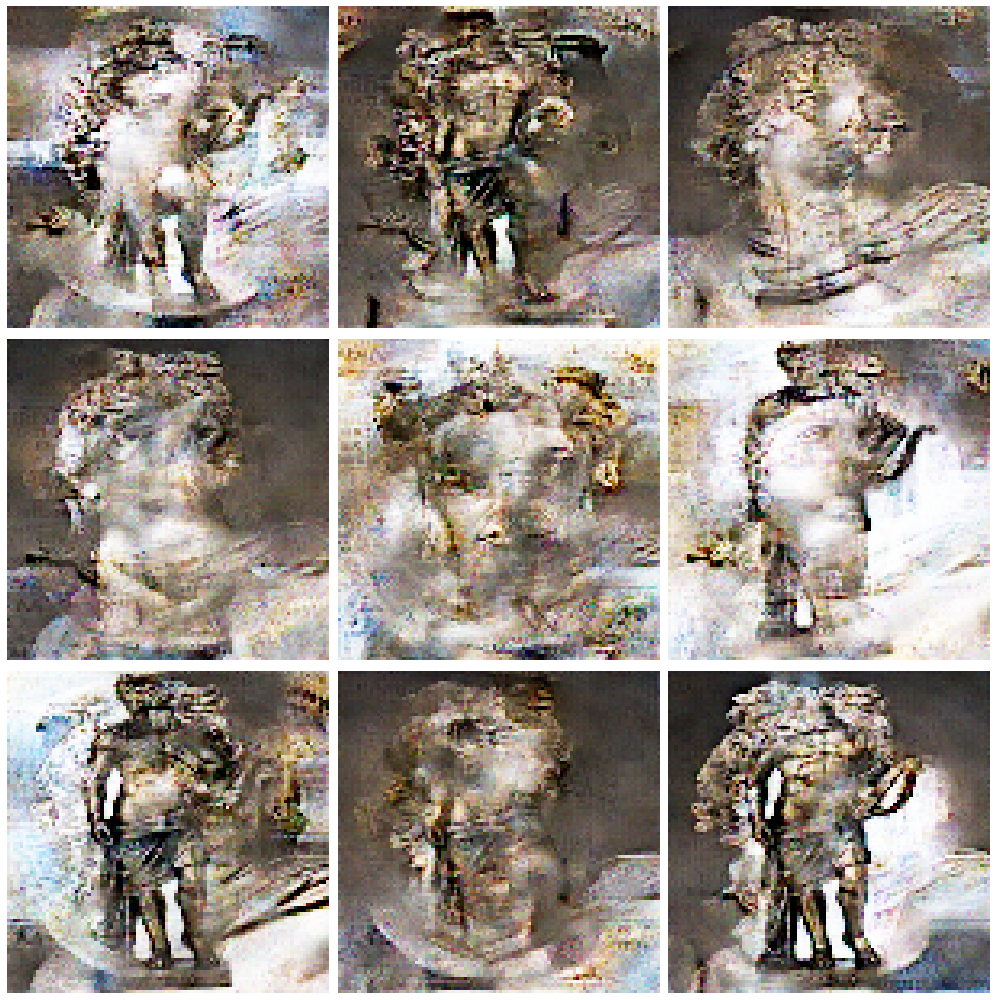

In [80]:
figure, axes = plt.subplots(nrows=3,ncols=3,figsize=(14,14))

for i,ax in enumerate(axes.flat):
    Prediction_Output = Generator_Predict[i*2]
    ax.imshow(Prediction_Output)
    ax.axis("off")
plt.tight_layout()
plt.show()

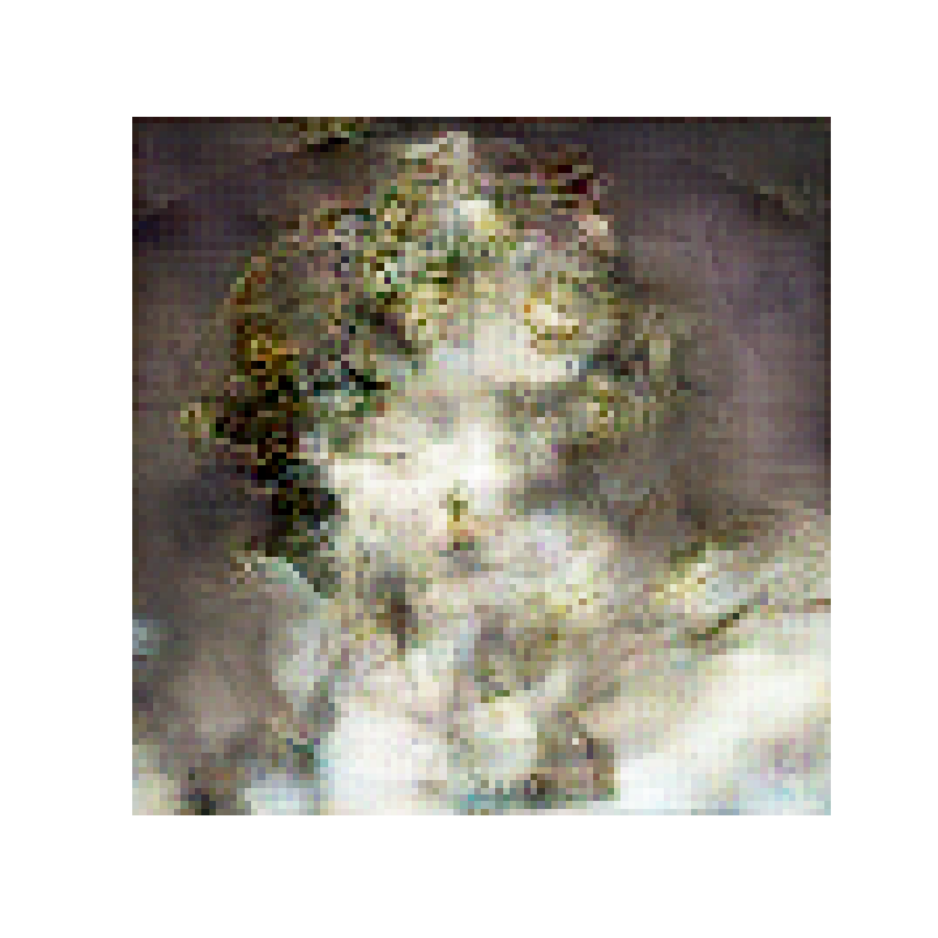

In [81]:
figure = plt.figure(figsize=(17,17))

Saving_Count = 5
plt.axis("off")
plt.imshow(Output_DCGAN[Saving_Count])
plt.savefig(f"LIST{Saving_Count}_Output.png")